<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/PRMC-experimentos/blob/master/src/shift_invariance_in_OLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shift invariance in OLP

[Orthogonal Laplacian Pyramid (OLP)](https://sci-hub.tw/10.1109/TIP.2008.2001045) is used in [Progressive Resolution Motion Compensation (PRMC)](https://github.com/Sistemas-Multimedia/PRMC) for performing Motiom Estimation (ME) and Motion Compensation (MC), and both operations need to preserve the displacement of the compensated structures in the OLP, compared to the image domain. It would happen that if, for example, an object moves betweem two frames $A$ and $B$ one pixel in the horizontal direction, the same motion should be detected in the $[A.L]$ and $[A.H]$ subbands (see the [MCOLP butterfly](https://sistemas-multimedia.github.io/PRMC/#x1-170009.1)).

In [1]:
%matplotlib inline
from load_and_display import *

# The results depends on the wavelet (see http://wavelets.pybytes.com):
#wavelet = "haar"
wavelet = "bior3.5"
#wavelet = "rbio3.5"
#wavelet = "db5"
#wavelet = "db9"

In [3]:
%%bash

# Create the two images ("/tmp/moving_circle_000.png" and "/tmp/moving_circle_001.png") with a circle
# of diameter 10 that moves from coordinate (20,30) to (21,30).
/home/vruiz/MRVC/tools/moving_circle.sh -w 128 -h 128 -x 20 -y 30 -d 10 -f 2

/home/vruiz/MRVC/tools/moving_circle.sh: parsing: -w 128 -h 128 -x 20 -y 30 -d 10 -f 2
image_width = 128
image_height = 128
Initial X coordinate = 20
Initial Y coordinate = 30
diameter = 10
frames = 2


+ i=0
+ '[' 0 -le 1 ']'
++ printf %03d 0
+ ii=000
+ convert -size 128x128 xc:skyblue -fill white -stroke black -draw 'circle 20,30 30,30' /tmp/moving_circle_000.png
+ i=1
+ '[' 1 -le 1 ']'
++ printf %03d 1
+ ii=001
+ convert -size 128x128 xc:skyblue -fill white -stroke black -draw 'circle 21,30 31,30' /tmp/moving_circle_001.png
+ i=2
+ '[' 2 -le 1 ']'


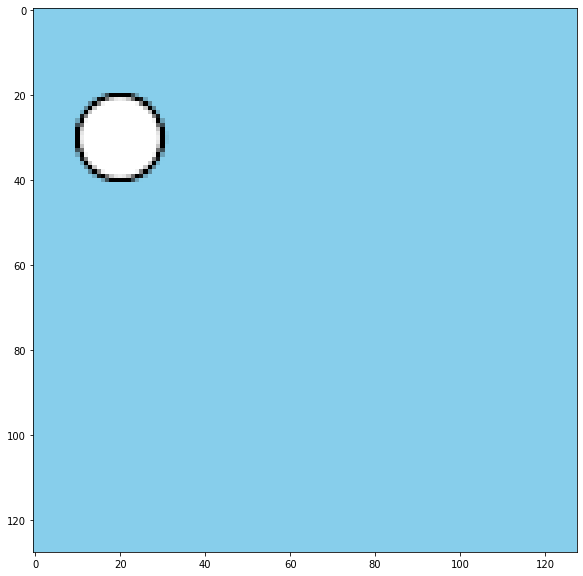

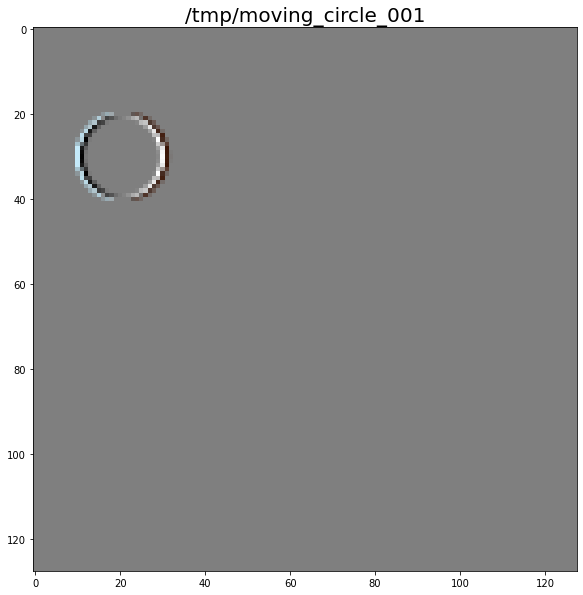

In [4]:
show_motion(prefix="/tmp/moving_circle_", frames=2)

In [6]:
%%bash

# The images are in the RGB domain and we work in the YUV domain, so we convert them.
/home/vruiz/MRVC/tools/RGB2YUV.py -i /tmp/moving_circle_000.png -o /tmp/YUV_moving_circle_000.png
/home/vruiz/MRVC/tools/RGB2YUV.py -i /tmp/moving_circle_001.png -o /tmp/YUV_moving_circle_001.png

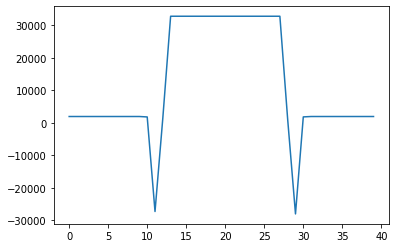

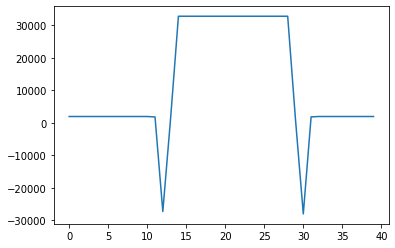

In [7]:
# Plot the first part (from pixel 0 to 39) of the horizontal line (row 35) of the luminance.
_000 = load_img("/tmp/moving_circle_000")
_001 = load_img("/tmp/moving_circle_001")
plt.plot(_000[35, 0:40, 0])
plt.show()
plt.plot(_001[35, 0:40, 0])
plt.show()

## Is $[L]$ subband shift invariant?

In [8]:
%%bash -s "$wavelet"

# DWT both images. The transform of the image with filename "X_.png" generates 4 subbands
# "X_LL.png", "X_LH.png", "X_HL.png" and $X_HH.png".
python3 -O DWT.py -p /tmp/YUV_moving_circle_ -i 000 -w $1
python3 -O DWT.py -p /tmp/YUV_moving_circle_ -i 001 -w $1

/usr/bin/python3: can't open file '/home/vruiz/Sistemas-Multimedia.github.io/study_guide/10-MC_in_DWT_domain/DWT.py': [Errno 2] No such file or directory
/usr/bin/python3: can't open file '/home/vruiz/Sistemas-Multimedia.github.io/study_guide/10-MC_in_DWT_domain/DWT.py': [Errno 2] No such file or directory


CalledProcessError: Command 'b'\n# DWT both images. The transform of the image with filename "X_.png" generates 4 subbands\n# "X_LL.png", "X_LH.png", "X_HL.png" and $X_HH.png".\npython3 -O DWT.py -p /tmp/YUV_moving_circle_ -i 000 -w $1\npython3 -O DWT.py -p /tmp/YUV_moving_circle_ -i 001 -w $1\n'' returned non-zero exit status 2.

In [9]:
show_motion(prefix="/tmp/YUV_moving_circle_LL", frames=2)

error: OpenCV(4.5.0) /build/opencv/src/opencv-4.5.0/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


<Figure size 720x720 with 0 Axes>

In [ ]:
_000 = load_img("/tmp/YUV_moving_circle_LL000")
_001 = load_img("/tmp/YUV_moving_circle_LL001")
plt.plot(_000[18, 0:20, 0])
plt.show()
plt.plot(_001[18, 0:20, 0])
plt.show()

It can be seen that a movement of a pixel in the original resolution of the frames ($128\times 128$) can not be represented without aliasing in the $L$ subband (with resolution $64\times 64$). But, what happens in the $[L]$?

In [ ]:
%%bash -s "$wavelet"

# Interpolate LL subbands of both images.

cp /tmp/YUV_moving_circle_LL000.png /tmp/copy_LL000.png 
python3 -O DWT.py -b -p /tmp/copy_ -i 000 -w $1

cp /tmp/YUV_moving_circle_LL001.png /tmp/copy_LL001.png 
python3 -O DWT.py -b -p /tmp/copy_ -i 001 -w $1

In [ ]:
show_motion(prefix="/tmp/copy_", frames=2)

In [ ]:
_000 = load_img("/tmp/copy_000")
_001 = load_img("/tmp/copy_001")
plt.plot(_000[35, 0:40, 0])
plt.show()
plt.plot(_001[35, 0:40, 0])
plt.show()

As can be seen, the reconstruction of the circle is not perfect, but we can intuit a movement of the structure one pixel in the X direction. Therefore, a motion estimator could indicate motion, especially if we use subpixel accuracy. In fact, if we interpolate again $[L]$ to get $[L]^2$.

In [ ]:
%%bash -s "$wavelet"

# Interpolate LL subbands of both images.

cp /tmp/copy_000.png /tmp/LLcopy_LL000.png
python3 -O DWT.py -b -p /tmp/LLcopy_ -i 000 -w $1

cp /tmp/copy_001.png /tmp/LLcopy_LL001.png 
python3 -O DWT.py -b -p /tmp/LLcopy_ -i 001 -w $1

In [ ]:
_000 = load_img("/tmp/LLcopy_000")
_001 = load_img("/tmp/LLcopy_001")
plt.plot(_000[70, 0:80, 0])
plt.show()
plt.plot(_001[70, 0:80, 0])
plt.show()

We can see that now the circle is better defined. In general, subpixel accuracy should improve ME and MC.

## Is $[H]$ (the overcomplete representation of $LH$, $HL$ and $HH$ in the OLP) subband shift invariant?

$H$ subband can be computed as
$$
[H] = A - [L]
$$
where $A$ is the original frame. Therefore, $[H]$ must be shift invariant in the same degree than $[L]$, and MC applied in he OLP should be accurate. However, for the sake of training with all this stuff (and to check that this is true), lets see the movement of the circle in the $[H]$ subband.

In [ ]:
%%bash -s "$wavelet"

# Remove output images that will store the H subbands.
#rm -f /tmp/YUV_moving_circle_000.png
#rm -f /tmp/YUV_moving_circle_001.png

# Get [H] by removing LL subband and performing inverse DWT.
rm -f /tmp/YUV_moving_circle_LL000.png
python3 -O DWT.py -b -p /tmp/YUV_moving_circle_ -i 000 -w $1
rm -f /tmp/YUV_moving_circle_LL001.png
python3 -O DWT.py -b -p /tmp/YUV_moving_circle_ -i 001 -w $1

In [ ]:
_000 = load_img("/tmp/YUV_moving_circle_000")
_001 = load_img("/tmp/YUV_moving_circle_001")
plt.plot(_000[35, 0:40, 0])
plt.show()
plt.plot(_001[35, 0:40, 0])
plt.show()

H is "near" shift invariant (the coefficiens more of less move with the true motion in the scene). The coefficients are not ideal (as it can be seen), but MC should hidden the recognizable structures. Example:

In [ ]:
plt.plot(np.roll(_000[35, 0:40, 0],1))
plt.show()
plt.plot(_001[35, 0:40, 0] - np.roll(_000[35, 0:40, 0],1))
plt.show()

Notice that the dynamic range of the "motion compensated" vector (the last one) is smaller than the original one.